## Vehicle Detection and Tracking

### Import

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

# Read in cars and notcars
imagepaths = ('vehicles/vehicles/GTI_Far/*.png',
              'vehicles/vehicles/GTI_Left/*.png',
              'vehicles/vehicles/GTI_MiddleClose/*.png',
              'vehicles/vehicles/GTI_Right/*.png',
              'vehicles/vehicles/KITTI_extracted/*.png')
cars = []
for imagefolder in imagepaths:
    print('Processing ', imagefolder, '...')
    images = glob.glob(imagefolder)
    
    for image in images:
        cars.append(image)

imagepaths = ('non-vehicles/non-vehicles/GTI/*.png',
              'non-vehicles/non-vehicles/Extras/*.png')
notcars = []
for imagefolder in imagepaths:
    print('Processing ', imagefolder, '...')
    images = glob.glob(imagefolder)
    
    for image in images:
        notcars.append(image)

# cars = cars[0:7000]
# notcars = notcars[0:7000]
print('# of cars: ',len(cars))
print('# of not cars: ',len(notcars))

Processing  vehicles/vehicles/GTI_Far/*.png ...
Processing  vehicles/vehicles/GTI_Left/*.png ...
Processing  vehicles/vehicles/GTI_MiddleClose/*.png ...
Processing  vehicles/vehicles/GTI_Right/*.png ...
Processing  vehicles/vehicles/KITTI_extracted/*.png ...
Processing  non-vehicles/non-vehicles/GTI/*.png ...
Processing  non-vehicles/non-vehicles/Extras/*.png ...
# of cars:  8792
# of not cars:  8968


### Feature Extraction

#### Define Features

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    features = np.hstack((color1,color2,color3))
    return features

# Define a function to compute color histogram features 
# bins_range=(0, 256) removed so no NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

# Define a function to extract features from a list of images
def extract_features(imglist,cspace='RGB',
                     spatial_feat=True,spatial_size=(32,32),
                     hist_feat=True,hist_bins=32,
                     hog_feat=True,orient=9,pix_cell=8,cell_block=2,hog_channel=0):
    
    features = []
    
    for imgfile in imglist:
        featuresimg = []
        img = mpimg.imread(imgfile)
        
        if cspace == 'HSV':
            featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
        else:
            featurecs = np.copy(img)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(featurecs,size=spatial_size)
            featuresimg.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(featurecs,nbins=hist_bins)
            featuresimg.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                featureshog = []
                for channel in range(featurecs.shape[2]):
                    featureshog.append(get_hog_features(featurecs[:,:,channel],
                                                       orient,pix_cell,cell_block,
                                                       vis=False,feature_vec=True))
                featureshog = np.ravel(featureshog)
            else:
                featureshog = get_hog_features(featurecs[:,:,hog_channel],
                                                       orient,pix_cell,cell_block,
                                                       vis=False,feature_vec=True)
                
            featuresimg.append(featureshog)
        features.append(np.concatenate(featuresimg))
    return features

# Define a function to extract features from a single image
def singleimg_features(img,cspace='RGB',
                     spatial_feat=True,spatial_size=(32,32),
                     hist_feat=True,hist_bins=32,
                     hog_feat=True,orient=9,pix_cell=8,cell_block=2,hog_channel=0,vis=False):
    
    features = []
    
    featuresimg = []

    if cspace == 'HSV':
        featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        featurecs = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        featurecs = np.copy(img)

    if spatial_feat == True:
        spatial_features = bin_spatial(featurecs,size=spatial_size)
        featuresimg.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(featurecs,nbins=hist_bins)
        featuresimg.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            featureshog = []
            for channel in range(featurecs.shape[2]):
                featureshog.append(get_hog_features(featurecs[:,:,channel],
                                                   orient,pix_cell,cell_block,
                                                   vis=False,feature_vec=True))
            featureshog = np.ravel(featureshog)
        else:
            if vis == True:
                featureshog, hogimage = get_hog_features(featurecs[:,:,hog_channel],
                                                   orient,pix_cell,cell_block,
                                                   vis=True,feature_vec=True)
            else:
                featureshog = get_hog_features(featurecs[:,:,hog_channel],
                                                   orient,pix_cell,cell_block,
                                                   vis=False,feature_vec=True)
        featuresimg.append(featureshog)
    features = np.concatenate(featuresimg)
    if vis == True:
        return features,hogimage
    else:
        return features

# Define a function for plotting multiple images
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

#### Set Feature Extraction Parameters

In [3]:
# color_space = 'YCbCr ' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 6  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off

color_space = 'YUV' #'RGB ' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 #6  # HOG orientations
pix_per_cell = 16 # 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 #0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#### Test Feature Extraction

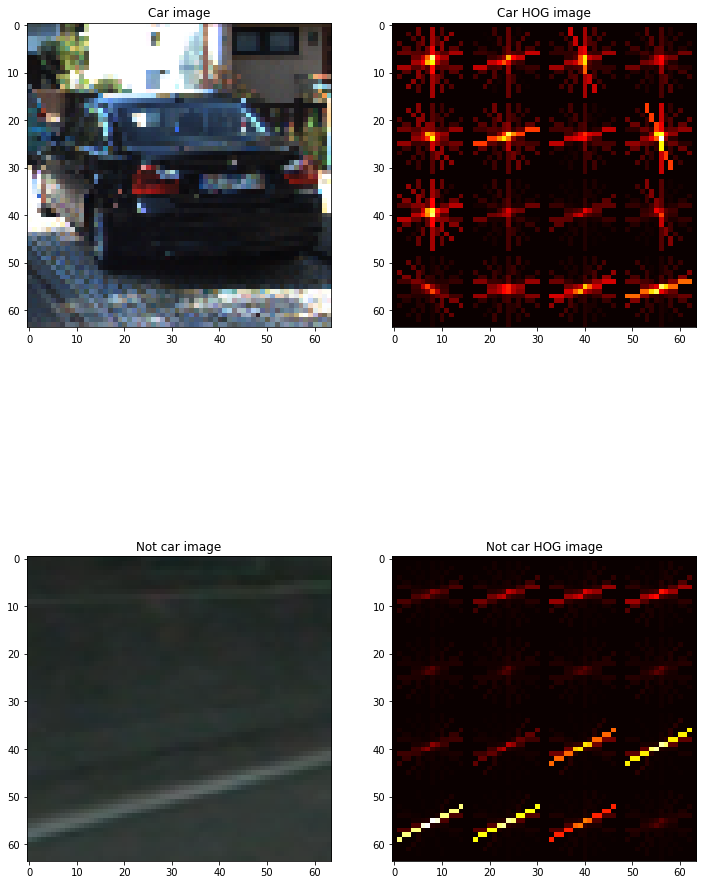

In [4]:
# Choose random car/not-car
caridx = np.random.randint(0,len(cars))
notcaridx = np.random.randint(0,len(notcars))

# Get sample images
carimg = mpimg.imread(cars[caridx])
notcarimg = mpimg.imread(notcars[notcaridx])

# Get features
car_features, carhogimg = singleimg_features(carimg, cspace=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, hist_bins=hist_bins, 
                        hog_feat=hog_feat, orient=orient, pix_cell=pix_per_cell, 
                        cell_block=cell_per_block, 
                        hog_channel=hog_channel,vis=True)
notcar_features, notcarhogimg = singleimg_features(notcarimg, cspace=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, hist_bins=hist_bins, 
                        hog_feat=hog_feat, orient=orient, pix_cell=pix_per_cell, 
                        cell_block=cell_per_block, 
                        hog_channel=hog_channel,vis=True)

images = [carimg,carhogimg,notcarimg,notcarhogimg]
titles = ['Car image','Car HOG image','Not car image','Not car HOG image']
fig = plt.figure(figsize=(12,18))
visualize(fig,2,2,images,titles)

#### Extract Features for Training

In [5]:
color_space = 'YUV' #'RGB ' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 #6  # HOG orientations
pix_per_cell = 16 # 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' #0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
car_features = extract_features(cars, cspace=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, hist_bins=hist_bins, 
                        hog_feat=hog_feat, orient=orient, pix_cell=pix_per_cell, 
                        cell_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, hist_bins=hist_bins, 
                        hog_feat=hog_feat, orient=orient, pix_cell=pix_per_cell, 
                        cell_block=cell_per_block, 
                        hog_channel=hog_channel)

print(round(time.time()-t,2), ' Seconds to extract features for training.')

109.84  Seconds to extract features for training.


#### Post Processing Features

In [6]:
print('Total car samples: ',len(car_features))
print('Total not car samples: ',len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

cars = None
notcars = None
X = None
scaled_X = None

Total car samples:  8792
Total not car samples:  8968
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4140


### Train Classifier

In [7]:
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

24.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


### Perform Sliding Window Search

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = singleimg_features(test_img, cspace=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, hist_bins=hist_bins, 
                        hog_feat=hog_feat, orient=orient, pix_cell=pix_per_cell, 
                        cell_block=cell_per_block, 
                        hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Test Sliding Window Search

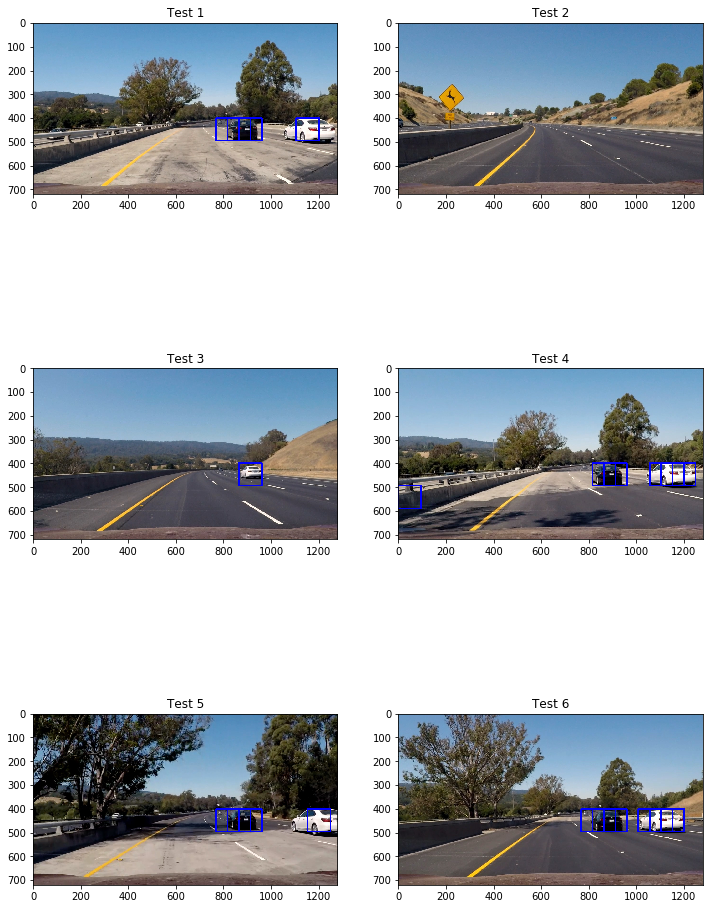

In [9]:
imglist = glob.glob('test_images/*.jpg')

imgout = []
for imgfile in imglist:
    image = mpimg.imread(imgfile)
    draw_image = np.copy(image)


    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    y_start_stop = [400, 656] # Min and max in y to search in slide_window()


    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    imgout.append(window_img)
    
titles = ['Test 1','Test 2','Test 3','Test 4','Test 5','Test 6']
fig = plt.figure(figsize=(12,18))
visualize(fig,3,2,imgout,titles)

### Reduce Multiple/False Detections

#### Heat Map Thresholding

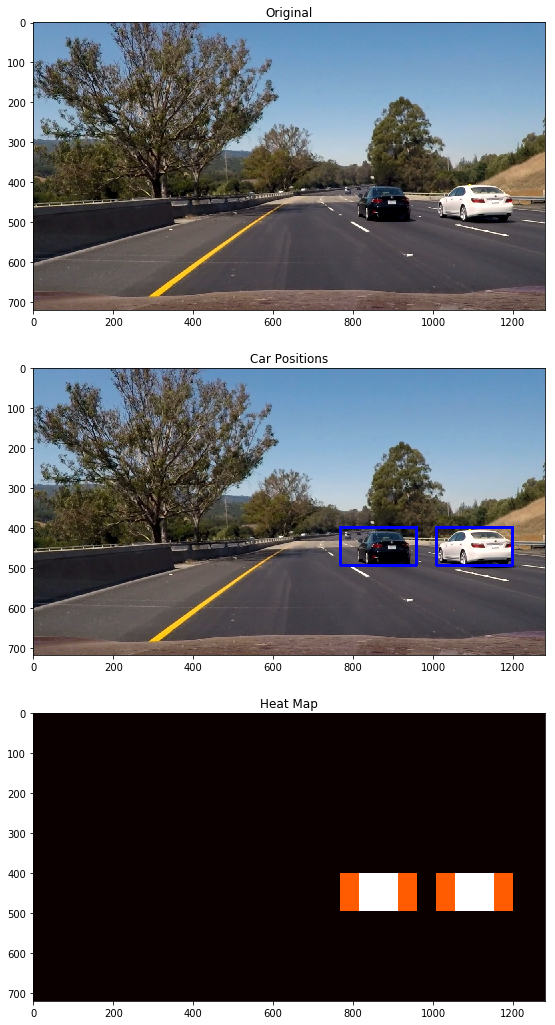

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (np.max(nonzerox) - np.min(nonzerox)) * (np.max(nonzeroy) - np.min(nonzeroy))
        if area > 2000:
            # Draw the box on the image
#             print(area)
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_img

# Test image
image = mpimg.imread('test_images/test6.jpg')

# Initialize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
# print(np.min(heat))
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(image, labels)

imgs = [image,draw_img,heatmap]
titles = ['Original','Car Positions','Heat Map']
fig = plt.figure(figsize=(12,18))
visualize(fig,3,1,imgs,titles)

#### HoG Subsampling

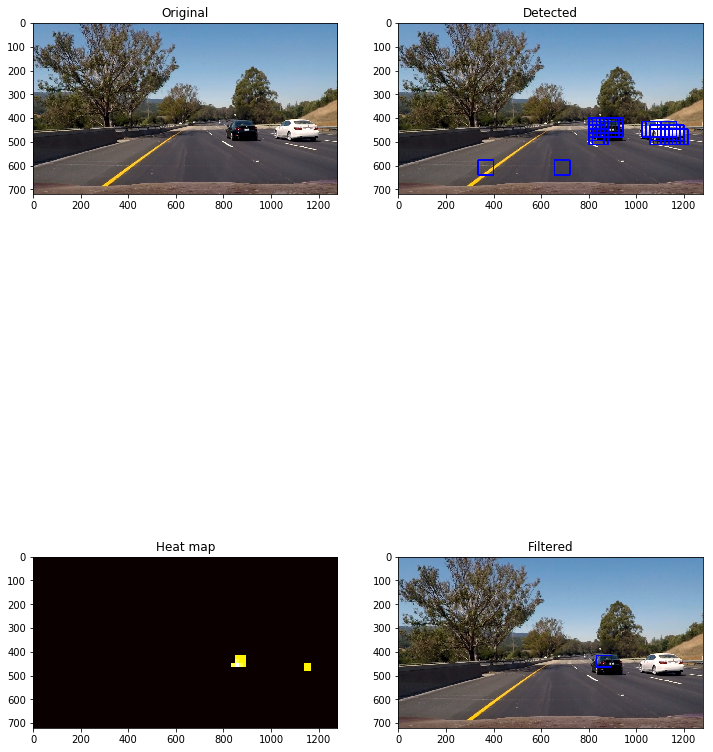

In [11]:
# Define a function for color conversion
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxlist = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            bbox = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append((xbox_left, ytop_draw+ystart))
                bbox.append((xbox_left+win_draw, ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxlist.append(bbox)
#     print(len(bboxlist))
    return draw_img, bboxlist

ystart = 400
ystop = 656
scale = 1.0

out_img,bboxlist = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Initialize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bboxlist)
# print(np.max(heat))
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,7)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

imgs = [image,out_img,heatmap,draw_img]
titles = ['Original','Detected','Heat map','Filtered']
fig = plt.figure(figsize=(12,18))
visualize(fig,2,2,imgs,titles)

### Test Video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

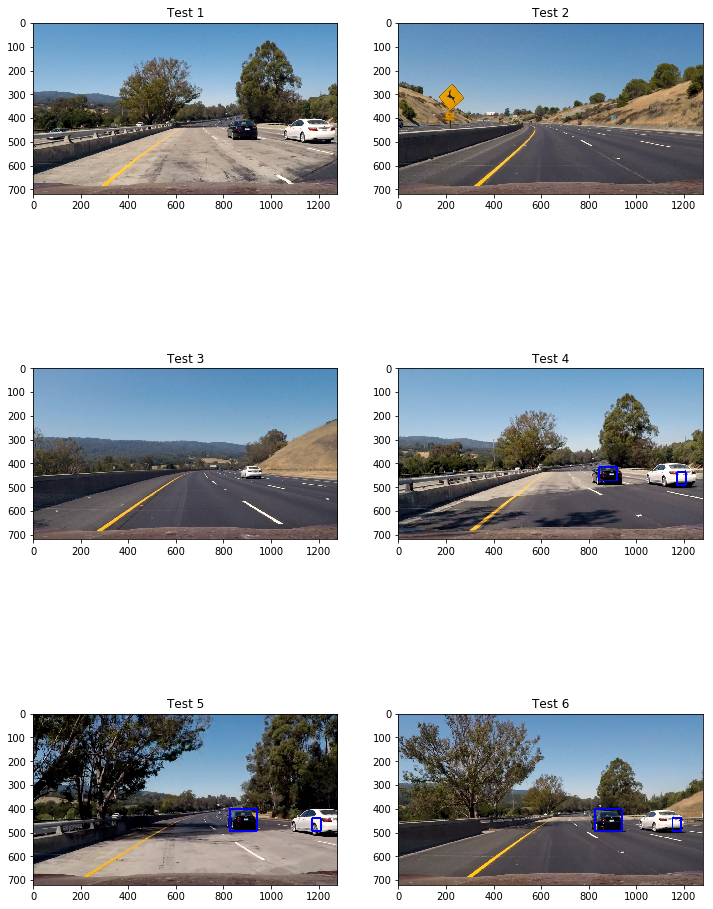

In [13]:
def process_img(image):
    
    # Find cars
    out_img,bboxlist = find_cars(image, process_img.y_start_stop[0], process_img.y_start_stop[1], process_img.scale, 
                                 process_img.classifier, process_img.scaler, 
                                 process_img.orient, process_img.pix_per_cell, process_img.cell_per_block, 
                                 process_img.spatial_size, process_img.hist_bins)
    
    # Initialize heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bboxlist)
    
    # Uncomment the following piece of code for video frames to threshold over last 5 frames
    # Add heat map to the queue
    process_img.heat5.append(heat)
    accumulated_heat = 0
    for idx in range(0,len(process_img.heat5)):
#         print(idx+1,' heatmap(s) accumulated')
        accumulated_heat = accumulated_heat + process_img.heat5[idx]
    heat = accumulated_heat

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,process_img.threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img


process_img.orient = orient  # HOG orientations
process_img.pix_per_cell = pix_per_cell # HOG pixels per cell
process_img.cell_per_block = cell_per_block # HOG cells per block
process_img.spatial_size = spatial_size # Spatial binning dimensions
process_img.hist_bins = hist_bins    # Number of histogram bins
process_img.y_start_stop = (400, 656)
process_img.classifier = svc #Trained classifier model
process_img.scaler = X_scaler #Specified scaler
process_img.threshold = 10
process_img.scale = 1.2
process_img.heat5 = deque(maxlen = 5)

# process_img.spatial_feat = spatial_feat # Spatial features on or off
# process_img.hist_feat = hist_feat # Histogram features on or off
# process_img.hog_feat = hog_feat # HOG features on or off
# process_img.color_space = color_space # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# process_img.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"

# Test pipeline
imglist = glob.glob('test_images/*.jpg')

imgout = []
for imgfile in imglist:
    image = mpimg.imread(imgfile)
#     process_img.heat5 = deque(maxlen = 5)
    result = process_img(image)
    imgout.append(result)
    
titles = ['Test 1','Test 2','Test 3','Test 4','Test 5','Test 6']
fig = plt.figure(figsize=(12,18))
visualize(fig,3,2,imgout,titles)

In [14]:
project_output = 'test_videos_output/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
process_img.heat5 = deque(maxlen = 5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,20)
# clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_output.mp4
[MoviePy] Writing video test_videos_output/project_output.mp4


100%|██████████████████████████████▉| 1260/1261 [37:05<00:01,  1.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_output.mp4 

Wall time: 37min 7s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/project_output.mp4" type="video/mp4">
</video>
""".format(project_output))